# Totori_AI

## 음운 인식
### 1. 음운 분석
- 예외 처리
- 자모 분해 로직
- 편집 거리(Levenshtein Distance)
- 오류 유형 분류 (대치, 탈락, 첨가)
- 데이터 정규화

In [43]:
# 환경설정
!pip install jamo
!pip install openai

import os
import json
import re
from openai import OpenAI
from jamo import h2j, j2hcj
from collections import Counter

client = OpenAI(api_key=openai_api_key)

In [3]:
# 전처리
def clean_text(text):
  text = re.sub(r'[^\w\s]', '', text)
  return text.split()

In [4]:
# 한글을 자모로 분리
def get_jamo_list(text):
  jamo_str = j2hcj(h2j(text))
  return list(jamo_str)

In [5]:

print(get_jamo_list("강아지는 밥을"))

['ㄱ', 'ㅏ', 'ㅇ', 'ㅇ', 'ㅏ', 'ㅈ', 'ㅣ', 'ㄴ', 'ㅡ', 'ㄴ', ' ', 'ㅂ', 'ㅏ', 'ㅂ', 'ㅇ', 'ㅡ', 'ㄹ']


In [6]:
# 편집 거리
def levenshtein_distance(s1, s2):
  m, n = len(s1), len(s2)
  dp = [[0] * (n + 1) for _ in range(m + 1)]

  for i in range(m + 1):
    dp[i][0] = i
  for j in range(n + 1):
    dp[0][j] = j

  for i in range(1, m + 1):
    for j in range(1, n + 1):
      if s1[i-1] == s2[j-1]:
        dp[i][j] = dp[i-1][j-1]
      else:
        dp[i][j] = 1 + min(dp[i-1][j], # 삭제
                            dp[i][j-1], # 추가
                            dp[i-1][j-1]) # 대치
  return dp[m][n]

In [7]:
word1 = get_jamo_list("strong")
word2 = get_jamo_list("stone")
print(f"편집 거리: {levenshtein_distance(word1, word2)}")

편집 거리: 2


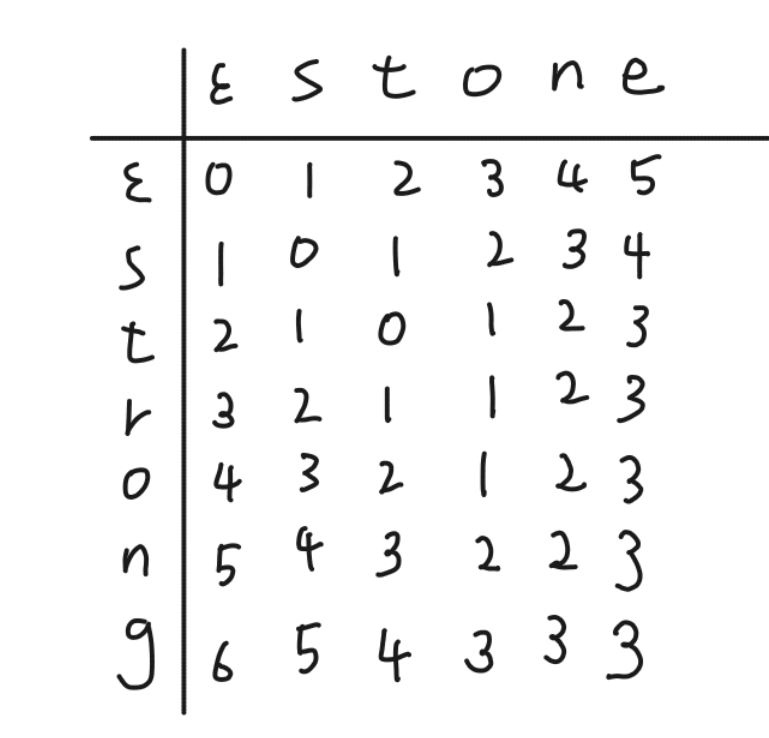

In [8]:
def get_alignment(s1, s2):
    m, n = len(s1), len(s2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1): dp[i][0] = i
    for j in range(n + 1): dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])

    align1, align2 = [], []
    i, j = m, n

    while i > 0 or j > 0:
        # 일치
        if i > 0 and j > 0 and s1[i-1] == s2[j-1]:
            align1.append(s1[i-1])
            align2.append(s2[j-1])
            i -= 1; j -= 1
        # 대치
        elif i > 0 and j > 0 and dp[i][j] == dp[i-1][j-1] + 1:
            align1.append(s1[i-1])
            align2.append(s2[j-1])
            i -= 1; j -= 1
        # 탈락
        elif i > 0 and dp[i][j] == dp[i-1][j] + 1:
            align1.append(s1[i-1])
            align2.append("-")
            i -= 1
        # 첨가
        else:
            align1.append("-")
            align2.append(s2[j-1])
            j -= 1

    return align1[::-1], align2[::-1]

In [9]:

ref = get_jamo_list("강아지")
hyp = get_jamo_list("가아지")
a1, a2 = get_alignment(ref, hyp)
print(f"정답 : {a1}")
print(f"인식 : {a2}")

정답 : ['ㄱ', 'ㅏ', 'ㅇ', 'ㅇ', 'ㅏ', 'ㅈ', 'ㅣ']
인식 : ['ㄱ', 'ㅏ', '-', 'ㅇ', 'ㅏ', 'ㅈ', 'ㅣ']


In [10]:
def get_error_report(a1, a2):
  errors = []
  for char1, char2 in zip(a1, a2):
    if char1 != char2:
      if char2 == "-":
        errors.append(f"{char1} 탈락")
      elif char1 == "-":
        errors.append(f"{char2} 첨가")
      else:
        errors.append(f"{char1} -> {char2} 대치")
  return errors

In [11]:
errors = get_error_report(a1, a2)
print(f"{errors}")

['ㅇ 탈락']


In [31]:
# 음운 분석 종합
def analyze_session(original_text:str, stt_text:str):
  org_words = clean_text(original_text)
  stt_words = clean_text(stt_text)

  aligned_org, aligned_stt = get_alignment(org_words, stt_words)

  total_error = []
  mismatched_pairs = []

  for o_word, s_word in zip(aligned_org, aligned_stt):
    if o_word != s_word:
      if o_word == "-" or s_word == "-":
        total_error.append(f"단어 {o_word if o_word != '-' else s_word} 읽기 오류")
      else:
        org_jamo = get_jamo_list(o_word)
        stt_jamo = get_jamo_list(s_word)
        a1, a2 = get_alignment(org_jamo, stt_jamo)
        errors = get_error_report(a1, a2)

        total_error.append(errors)
        mismatched_pairs.append(o_word)
  total_error_reports = sum(total_error, [])
  return total_error_reports, mismatched_pairs

In [54]:
original = "강아지가 숲길을 신나게 달려요. 그때, 어떤 아이가 나타났어요."
stt_result = "강아지가 숲길을 시나게 달료요. 그대, 어떤 아이가 나타났어요."
error_reports, error_words = analyze_session(original, stt_result)


In [55]:
# 오류 유형-틀린 단어 딕셔너리화
report_dict = {}
for i in range(len(error_reports)):
  report_dict[error_reports[i]] = error_words[i]

print(report_dict)
print("발견된 음운 오류:", error_reports)
print("틀린 단어들:", error_words)

{'ㄴ 탈락': '신나게', 'ㅕ -> ㅛ 대치': '달려요', 'ㄸ -> ㄷ 대치': '그때'}
발견된 음운 오류: ['ㄴ 탈락', 'ㅕ -> ㅛ 대치', 'ㄸ -> ㄷ 대치']
틀린 단어들: ['신나게', '달려요', '그때']


### 2. 단어 학습 추천
- 오류 유형 통계
- 유사 단어 추출 or GPT

In [35]:
# 오류 유형 최빈값 찾기
def errors_count(reports):
  counter = Counter(reports).most_common(1)
  return counter

In [36]:
count = errors_count(error_reports)
print(count)
print(count[0][0])

[('ㄴ 탈락', 2)]
ㄴ 탈락


In [56]:
# 단어 선택
target_word = report_dict.get(count[0][0])
print(target_word)

신나게


In [57]:
# GPT 단어 추천
def get_recommendations_gpt(target_word, error_pattern):
  system_prompt = """
  당신은 난독 아동을 돕는 언어 치료사입니다.
  아동이 단어를 읽을 때 발생한 음운 오류 패턴을 분석하여, 학습에 도움이 되는 단어 5개를 추천해야 합니다.
  첫 번째 단어는 아이가 방금 틀린 원래 단어여야 합니다.
  나머지 4개는 해당 오류 패턴을 연습할 수 있는 음운 구조를 가진 유사한 난이도의 단어여야 합니다.
  모든 단어는 초등학교 수준의 쉬운 단어여야 합니다.
  결과는 반드시 JSON 형식으로만 출력하세요.
  """
  user_prompt = f"""
  아이가 방금 틀린 원래 단어: {target_word}
  발견된 오류 패턴: {error_pattern}
  위 데이터를 바탕으로 단어 5개를 추천해줘.
  """

  response = client.chat.completions.create(
      model = "gpt-4o-mini",
      messages = [
          {"role": "system", "content": system_prompt},
          {"role": "user", "content": user_prompt}
      ],
      response_format = {"type":"json_object"}
  )

  result = json.loads(response.choices[0].message.content)
  return result

In [58]:
recommended_words = get_recommendations_gpt(target_word, count[0][0])
print(json.dumps(recommended_words, indent=2, ensure_ascii=False))

{
  "original_word": "신나게",
  "recommended_words": [
    "신발",
    "신선",
    "신호",
    "신기"
  ]
}



### 3. 데이터 저장
- 분석 결과, 학습 데이터 저장

### 4. 다음 동화 생성 반영
- 프롬프팅
- 난이도 조절 알고리즘